# BERT Tutorial
### Part II of aBIM on Transformers & BERT

BERT has a very complex structure and training process but using it, fine tuning it and integrating it is very easy. `HuggingFace` is a hub providing access to all types of transformer based models via its `transformers` library.

<img src="https://miro.medium.com/max/1400/1*PMlT7m9nMigseMmJcB4ddw.png" width = 800>

https://huggingface.co/models

Table of Contents
1. Hugginface's BERT syntax
2. Text classification using BERT embeddings
3. Visualizing embedded text with dimensionality reduction
4. Integrating BERT into production (Flask)


Reminder: BERT based models have 3 main parameters usually noted like this: l / h / a
- l: layers (how many encoders are built on top of each other)
- h: hidden layers (embedding dimensions)
- a: attention heads (# of heads in multi head attention)

| Model | Structure | Parameters |
| --- | --- | --- |
| BERT base | 12 / 768 / 12 | 110m |
| BERT large | 24 / 1024 / 16 | 340m |
| DistilBERT | 6 / 768 / 12 | 66m |

In [1]:
import sys
import torch
from transformers import __version__ as transformers_version
import pandas as pd

print('Python version:', sys.version)
print('PyTorch version:', torch.__version__)
print('Transformers version:', transformers_version)

Python version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 1.11.0
Transformers version: 4.21.2


### Do we have GPU?

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce MX330'

In [4]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce MX330', major=6, minor=1, total_memory=2047MB, multi_processor_count=3)

Set auto device to GPU for PyTorch (and transformers)

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Will use:', device)

Will use: cuda:0


## PART I - Getting to know the HuggingFace syntax

### How to use BERT (and BERT-based) models?

Luckily HuggingFace is the hub for all transformers, so the syntax is the same for any BERT model we want to use. Same loading, training, predicting, saving, etc... You learn it once, you can apply it to everything.


Let's choose a smallert BERT (to speed things up): Distilbert, uncased --> text will need to be turned to lowercase before applying model.

Every BERT model has 2 parts, both need to be loaded:
1. Tokenizer (turns text into tokens to be fed into BERT)
2. Model (takes the tokenized input and creates the embeddings, can also be fine tuned by training additional layers for classification)

In [6]:
from transformers import DistilBertTokenizer, DistilBertModel # if using TensorFlow, models will have a TF_ prefix (TFDistilBertModel)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Check tokenizer

In [7]:
tokenizer

PreTrainedTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [8]:
text = "I don't like running"

In [9]:
tokenizer.encode(text)

[101, 1045, 2123, 1005, 1056, 2066, 2770, 102]

In [10]:
tokenizer.encode(text, return_tensors='np')

array([[ 101, 1045, 2123, 1005, 1056, 2066, 2770,  102]])

In [11]:
tokenizer.encode(text, return_tensors='pt')
#tokenizer.encode(text, return_tensors='tf')

tensor([[ 101, 1045, 2123, 1005, 1056, 2066, 2770,  102]])

In [12]:
tokenizer.encode_plus(text, return_tensors='pt')

{'input_ids': tensor([[ 101, 1045, 2123, 1005, 1056, 2066, 2770,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [13]:
tokenizer.convert_ids_to_tokens(tokenizer.encode_plus(text, return_tensors='pt')['input_ids'][0])

['[CLS]', 'i', 'don', "'", 't', 'like', 'running', '[SEP]']

When to use padding? When there are multiple input sequences, and their lengths are different

In [14]:
texts = ["I don't like running", 
         "I enjoy delicious Napoletan pizza", 
         "Do you like swimming in salty water?"]

tokenized_texts = tokenizer.batch_encode_plus(texts, return_tensors='pt', padding = True)

for i in range(tokenized_texts['input_ids'].shape[0]):
    print(tokenizer.convert_ids_to_tokens(tokenized_texts['input_ids'][i])) 

['[CLS]', 'i', 'don', "'", 't', 'like', 'running', '[SEP]', '[PAD]', '[PAD]']
['[CLS]', 'i', 'enjoy', 'delicious', 'nap', '##ole', '##tan', 'pizza', '[SEP]', '[PAD]']
['[CLS]', 'do', 'you', 'like', 'swimming', 'in', 'salty', 'water', '?', '[SEP]']


In [15]:
for i in range(tokenized_texts['input_ids'].shape[0]):
    print(tokenized_texts['attention_mask'][i])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


### Check BERT model

In [16]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.2",
  "vocab_size": 30522
}

In [17]:
model.embeddings

Embeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [18]:
model.num_parameters()

66362880

How to use model?

In [19]:
print(text)
print(tokenizer.encode(text))
print(tokenizer.encode(text, return_tensors='pt'))

I don't like running
[101, 1045, 2123, 1005, 1056, 2066, 2770, 102]
tensor([[ 101, 1045, 2123, 1005, 1056, 2066, 2770,  102]])


In [27]:
try:
    model(tokenizer.encode(text))
except AttributeError as error:
    print(error)

'list' object has no attribute 'size'


In [28]:
model(tokenizer.encode(text, return_tensors='pt'))

BaseModelOutput(last_hidden_state=tensor([[[ 0.0652,  0.0028, -0.0174,  ...,  0.0461,  0.1736,  0.3138],
         [ 0.4311,  0.1628, -0.1936,  ..., -0.0356,  0.2380,  0.5381],
         [-0.1097,  0.3686,  0.4179,  ..., -0.3509,  0.0401,  0.1781],
         ...,
         [ 0.4491,  0.1565,  0.6133,  ..., -0.1435, -0.2276, -0.1262],
         [ 0.4262, -0.4698, -0.5305,  ...,  0.1044, -0.5408, -0.0299],
         [ 0.3381,  0.1836,  0.2806,  ...,  0.3698, -0.0713,  0.0624]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

In [29]:
output = model(tokenizer.encode(text, return_tensors='pt'))
#output = model(**tokenizer.encode_plus(text, return_tensors='pt')) # here we return input_ids AND attention_masks so the ** lets the function map the dictionary's keys to its parameters

In [30]:
output.keys()

odict_keys(['last_hidden_state'])

In [31]:
output.last_hidden_state

tensor([[[ 0.0652,  0.0028, -0.0174,  ...,  0.0461,  0.1736,  0.3138],
         [ 0.4311,  0.1628, -0.1936,  ..., -0.0356,  0.2380,  0.5381],
         [-0.1097,  0.3686,  0.4179,  ..., -0.3509,  0.0401,  0.1781],
         ...,
         [ 0.4491,  0.1565,  0.6133,  ..., -0.1435, -0.2276, -0.1262],
         [ 0.4262, -0.4698, -0.5305,  ...,  0.1044, -0.5408, -0.0299],
         [ 0.3381,  0.1836,  0.2806,  ...,  0.3698, -0.0713,  0.0624]]],
       grad_fn=<NativeLayerNormBackward0>)

In [32]:
output.last_hidden_state.shape

torch.Size([1, 8, 768])

In [33]:
output.last_hidden_state[0].shape

torch.Size([8, 768])

In [34]:
output.last_hidden_state[0][0].shape

torch.Size([768])

In [35]:
output.last_hidden_state[0][0].detach().numpy().shape

(768,)

### We haven't been using GPU!

With PyTorch it's very easy, you literally tell your processes to put them onto the GPU with `.to(device)`

In [36]:
model = model.to(device)

In [37]:
encoded_texts = tokenizer.batch_encode_plus(texts*10, return_tensors='pt', padding = True).to(device)
output = model(**encoded_texts)

In [38]:
torch.cuda.empty_cache()

Using GPU would help a lot, but even this BERT model is too big, already uses a lot of GPU memory, so I'll use CPU later. But a strong GPU with nice vram does wonders.


Can we simply access stuff that's on GPU?

In [39]:
try:
    encoded_texts['input_ids'][0].numpy()
except TypeError as error:
    print(error)

can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


In [40]:
encoded_texts['input_ids'][0].cpu().numpy()

array([ 101, 1045, 2123, 1005, 1056, 2066, 2770,  102,    0,    0],
      dtype=int64)

## PART II - Simple Text Classification

Will use a simple logistic regression for all scenarios



<img src='https://jalammar.github.io/images/distilBERT/bert-distilbert-sentence-classification-example.png' width=1000>


The goal is to fill this table's eval metric column:

| Applied Model | Text Preprocessing | AUC | AP |
| --- | --- | --- | --- |
| tf-idf | Extensive (lower, spec/numb/stop removed, lemmatized) | | |
| tf-idf | Minimal (lower, spec/numb removed) | | |
| tf-idf | Nothing (lower) |  | |
| BERT | Extensive (lower, spec/numb/stop removed, lemmatized) |   | |
| BERT | Minimal (lower, spec/numb removed) |  | |
| BERT | Nothing (lower) | | |

In [41]:
import re

# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
STOP_WORDS = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

def text_cleaner_extensive(text):  
    
    # lower chars and treat whitespaces
    text = text.lower()
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces  

    # delete special characters and numbers
    text = re.compile('[^a-z]').sub(' ', text) 
    
    # after numbers
    text = re.sub(' th ', '', text)
    text = re.sub(' st ', '', text)
    text = re.sub(' nd ', '', text)
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces 
    
    # stopwords
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    
    # lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    # final whitespace treatment
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces 
    
    return text

def text_cleaner_minimal(text):  
    
    # lower chars and treat whitespaces
    text = text.lower()
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces  

    # delete special characters and numbers
    text = re.compile('[^a-z]').sub(' ', text) 
    
    # after numbers
    text = re.sub(' th ', '', text)
    text = re.sub(' st ', '', text)
    text = re.sub(' nd ', '', text)
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces 
    
    # final whitespace treatment
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces 
    
    return text

### 1. Clean text

In [42]:
%%time

data = pd.read_csv('https://github.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/blob/master/spam.csv?raw=true', 
                    on_bad_lines='skip', 
                    encoding = "ISO-8859-1", 
                    usecols=[0, 1])

data.columns = ['is_spam', 'text']
data['is_spam'].replace({'ham' : 0, 'spam' : 1}, inplace = True)

data['text_lower'] = data['text'].apply(lambda x: x.lower())
data['text_cleaned_minimal'] = data['text'].apply(lambda x: text_cleaner_minimal(x))
data['text_cleaned_extensive'] = data['text'].apply(lambda x: text_cleaner_extensive(x))


print('Shape of data:', data.shape)
print('Ratio of spam:', round(data.loc[data['is_spam'] == 1].shape[0] / data.shape[0] * 100, 2), '%')

data.head(3)

Shape of data: (5572, 5)
Ratio of spam: 13.41 %
Wall time: 3 s


,is_spam,text,text_lower,text_cleaned_minimal,text_cleaned_extensive
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in a wkly comp to win fa cup final ...,free entry wkly comp win fa cup final tkts may...


How long is 1 message usually? (# of words)

In [43]:
data.drop(labels = 'is_spam', axis = 1).applymap(lambda x: len(x.split())).describe(percentiles = [.5, .75, .9, .99]).astype(int).T

,count,mean,std,min,50%,75%,90%,99%,max
text,5572,15,11,1,12,23,29,54,171
text_lower,5572,15,11,1,12,23,29,54,171
text_cleaned_minimal,5572,15,11,0,12,22,29,54,190
text_cleaned_extensive,5572,8,6,0,7,13,18,29,77


90% of original messages are less, than 30 words, 75% of them are less than 25. For BERT, I'll set max length to 25, each word after that will be 'deleted'.

In [44]:
MAX_LENGTH = 25

for text_col in ['text_lower', 'text_cleaned_minimal', 'text_cleaned_extensive']:
    data[text_col] = data[text_col].str.split(n = MAX_LENGTH).str[:MAX_LENGTH].str.join(' ')

In [45]:
data.drop(labels = 'is_spam', axis = 1).applymap(lambda x: len(x.split())).describe(percentiles = [.5, .75, .9, .99]).astype(int).T

,count,mean,std,min,50%,75%,90%,99%,max
text,5572,15,11,1,12,23,29,54,171
text_lower,5572,14,7,1,12,23,25,25,25
text_cleaned_minimal,5572,14,7,0,12,22,25,25,25
text_cleaned_extensive,5572,8,5,0,7,13,18,25,25


### 2. Create embeddings (apply models)

In [46]:
# put BERT back to CPU
model = model.to('cpu')

In [47]:
%%time

# TF-IDF

tfidf = TfidfVectorizer(max_features=768).fit_transform(data['text_lower'])
tfidf_min = TfidfVectorizer(max_features=768).fit_transform(data['text_cleaned_minimal'])
tfidf_ext = TfidfVectorizer(max_features=768).fit_transform(data['text_cleaned_extensive'])

# BERT

tokenized_for_bert = tokenizer.batch_encode_plus(data['text_lower'], max_length = MAX_LENGTH+1, truncation = True, padding = True, return_tensors='pt')
tokenized_for_bert_min = tokenizer.batch_encode_plus(data['text_cleaned_minimal'], max_length = MAX_LENGTH+1, truncation = True, padding = True, return_tensors='pt')
tokenized_for_bert_ext = tokenizer.batch_encode_plus(data['text_cleaned_extensive'], max_length = MAX_LENGTH+1, truncation = True, padding = True, return_tensors='pt')

with torch.no_grad():

    # output dim of last_hidden_state: (datapoints, tokens, hidden layers) 
    # --> need all datapoints, just the 1st token ([CLS]) and all hidden layers (embeddings)
    # --> will take [:,0,:]

    bert = model(**tokenized_for_bert).last_hidden_state[:,0,:].numpy()
    bert_min = model(**tokenized_for_bert_min).last_hidden_state[:,0,:].numpy()
    bert_ext = model(**tokenized_for_bert_ext).last_hidden_state[:,0,:].numpy()

Wall time: 6min 14s


In [48]:
print(tfidf.shape)
print(tfidf_min.shape)
print(tfidf_ext.shape)

print(bert.shape)
print(bert_min.shape)
print(bert_ext.shape)

(5572, 768)
(5572, 768)
(5572, 768)
(5572, 768)
(5572, 768)
(5572, 768)


### 3. Apply logit and evaluate performance

In [49]:
Y = data['is_spam'].copy()

In [50]:
%%time

results = {'AUC' : {}, 'AP' : {}}
models = {}

for embedding_type, model_name in zip([tfidf, tfidf_min, tfidf_ext, bert, bert_min, bert_ext], 
                                      ['TF-IDF', 'TF-IDF with min prep', 'TF-IDF with extensive prep', 'BERT', 'BERT with min prep', 'BERT with extensive prep']):

    X_tr, X_test, Y_tr, Y_test = train_test_split(embedding_type, Y, train_size=0.8, random_state = 56)
    
    logit = LogisticRegression(random_state = 56, max_iter = 1000, n_jobs = -1)
    logit.fit(X_tr, Y_tr)

    Y_pred = logit.predict_proba(X_test)[:,1]

    auc = roc_auc_score(Y_test, Y_pred)
    ap = average_precision_score(Y_test, Y_pred)

    results['AUC'][model_name] = auc
    results['AP'][model_name] = ap
    models[model_name] = logit


Wall time: 1min 1s


Test set evaluation

In [51]:
pd.DataFrame.from_dict(results).sort_values('AUC', ascending = False)

,AUC,AP
BERT,0.994759,0.974023
BERT with min prep,0.986883,0.967645
BERT with extensive prep,0.983608,0.965354
TF-IDF with extensive prep,0.980602,0.950117
TF-IDF,0.978413,0.946756
TF-IDF with min prep,0.977882,0.945464


As we see:
- BERT beats tf-idf
- tf-idf needs extensive prep to have better performance
- BERT needs original text to perform best (BERT can use all type of information: stopwords, numbers, etc...)

## PART III - Some visualizations to compare tf-idf to BERT

In [52]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns

PCA (SVD for sparse matrices)

In [53]:
PCA_tfidf = TruncatedSVD(n_components=2, random_state=56).fit_transform(tfidf_ext)
PCA_bert = PCA(n_components=2, random_state=56).fit_transform(bert)

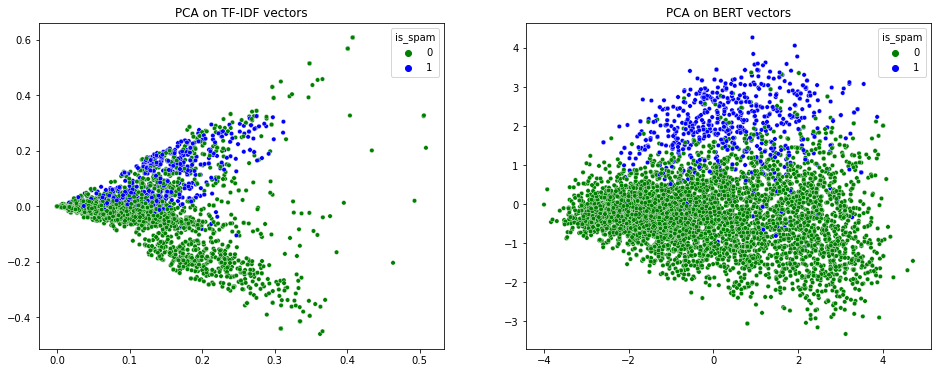

In [54]:
fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))
sns.scatterplot(x = PCA_tfidf[:,0], y = PCA_tfidf[:,1], s = 20, hue = Y, palette = {0 : 'green', 1 : 'blue'}, ax = ax[0])
sns.scatterplot(x = PCA_bert[:,0], y = PCA_bert[:,1], s = 20, hue = Y, palette = {0 : 'green', 1 : 'blue'}, ax = ax[1])
ax[0].set_title('PCA on TF-IDF vectors')
ax[1].set_title('PCA on BERT vectors')
plt.show()

tSNE

In [55]:
%%time

tSNE_tfidf = TSNE(random_state = 56, n_jobs = -1).fit_transform(tfidf_ext)
tSNE_bert = TSNE(random_state = 56, n_jobs = -1).fit_transform(bert)

Wall time: 1min 37s


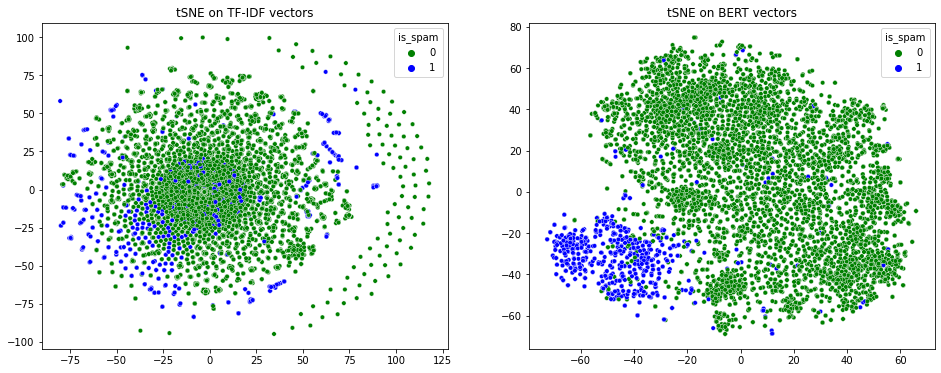

In [56]:
fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))
sns.scatterplot(x = tSNE_tfidf[:,0], y = tSNE_tfidf[:,1], s = 20, hue = Y, palette = {0 : 'green', 1 : 'blue'}, ax = ax[0])
sns.scatterplot(x = tSNE_bert[:,0], y = tSNE_bert[:,1], s = 20, hue = Y, palette = {0 : 'green', 1 : 'blue'}, ax = ax[1])
ax[0].set_title('tSNE on TF-IDF vectors')
ax[1].set_title('tSNE on BERT vectors')
plt.show()

## PART IV - Mini production - let's build the pipeline and be able to use our spam classifier

1. Input text
2. Preprocess it (lower)
3. Tokenize it
4. Apply BERT on it
5. Take BERT embeddings and apply logit on them
6. Predict probability and class

In [57]:
import pickle

In [58]:
# with open('../src/bert_tokenizer.pkl', 'wb') as file:
#     pickle.dump(tokenizer, file)

# with open('../src/bert_model.pkl', 'wb') as file:
#     pickle.dump(model, file)

# with open('../src/logit_model.pkl', 'wb') as file:
#     pickle.dump(models['BERT'], file)

In [59]:
with open('../src/bert_tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

with open('../src/bert_model.pkl', 'rb') as file:
    model = pickle.load(file)

with open('../src/logit_model.pkl', 'rb') as file:
    logit = pickle.load(file)

In [60]:
def predict(input_text:str, 
            bert_tokenizer:DistilBertTokenizer = tokenizer, 
            bert_model:DistilBertModel = model, 
            logit_model:LogisticRegression = logit) -> dict:

    # preprocess text
    text = input_text.lower()

    # tokenize text
    tokens = bert_tokenizer.encode_plus(text, max_length = 26, truncation = True, padding = True, return_tensors='pt')

    # create BERT embeddings
    with torch.no_grad():
        output = bert_model(**tokens)
    embeddings = output.last_hidden_state[:,0,:].numpy()

    # apply logit
    pred_prob = float(logit_model.predict_proba(embeddings)[:,1][0])
    pred_class = int(pred_prob > 0.5)

    return {'input_text' : input_text,
            'spam probability' : pred_prob,
            'spam class' : pred_class}

In [61]:
predict('Congrats, you won a brand new iPhone!')

{'input_text': 'Congrats, you won a brand new iPhone!',
 'spam probability': 0.8081183257749822,
 'spam class': 1}